<a href="https://colab.research.google.com/github/Josephnyingi/Crop-Disease-Detection/blob/main/Crop_leaf_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crop leaf disease dectetion**

---



# Problem statement

*   Crop diseases are heavily affected by disease which cause adverse effects on food security as well as economic losses

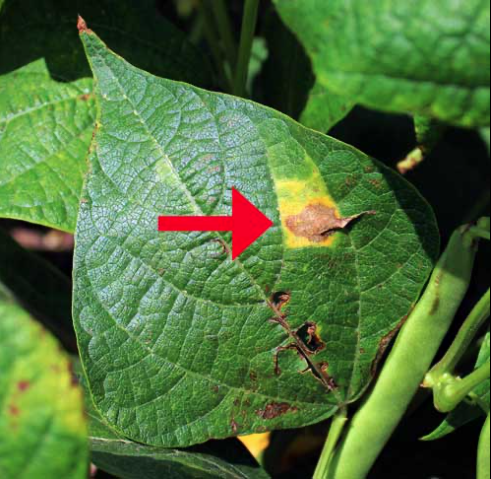



# Import libraries

In [ ]:
#Libraries
import pandas as pd
import keras
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
!pip install gdown
!apt-get update && apt-get install fil
!pip install keras_preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# Load Dataset

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
!pip install kaggle


Upload the kaggle.json file to your Google Colab environment using the following code

In [ ]:
from google.colab import files
files.upload()

After uploading the kaggle.json file, you need to move it to the /root/.kaggle directory in your Google Colab environment using the following code

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Finally, make sure the kaggle.json file has the right permissions using the following code

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

Kaggle API client in Google Colab

In [ ]:
!kaggle datasets download -d mohitsingh1804/plantvillage

Unzip the the Plantvillage.Zip folder

In [ ]:
# Unzip the downloaded file
!unzip -q /content/plantvillage.zip

Initializing a few parameters required for the image dataset preprocessing.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = '/content/PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively. And get number of images for training.

*NOTE: We use a small portion of the entire dataset due to the computing limitations. Tweak `N_IMAGES` to include entire dataset.*

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

Examine the labels/classes in the training dataset.

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [ ]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

# Build Model


Defining the hyperparameters of the plant disease classification model.

In [ ]:
EPOCHS = 25
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

# Train Model


We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

In [ ]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

# Save Model

In [ ]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

In [ ]:
predict_disease('/content/PlantVillage/val/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

In [ ]:
predict_disease('/content/PlantVillage/val/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

In [ ]:
predict_disease('/content/PlantVillage/val/Tomato___Target_Spot/1006b3dd-22d8-41b8-b83d-08bf189fcdaa___Com.G_TgS_FL 8118.JPG')

In [ ]:
predict_disease('/content/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/02459e0c-a189-4dc9-a0dc-0548e36d0efb___CREC_HLB 5714.JPG')

# Reuse Model

We download the trained model and label transform saved in the Google Drive.

In [ ]:
# Download the trained model file based on its file ID.
file_id = '1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl'
!gdown https://drive.google.com/uc?id={file_id}

# Download the labels file based on its file ID.
file_id = '1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu'
!gdown https://drive.google.com/uc?id={file_id}

Importing necessary libraries and modules required to build the classification model.

In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Load the trained model and its labels for prediction.

In [ ]:
# Load model
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

We use the `convert_image_to_array` function to resize an image and `predict_disease` function to predict the class or disease of a plant image.

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

Predict disease of any plant image.

In [ ]:
predict_disease('/content/PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/028159fc-995e-455a-8d60-6d377580a898___RS_NLB 4023.JPG')